# Recurrent Neural Networks for Time Series Forecasting: LTSM, GRU, Vanilla

In [1]:
# Load VMs
from DataExploration.BitbrainsUtils import load_all_VMs
VMs = load_all_VMs()

figures saved to ../Figures/DataExploration/


In [2]:
VM = VMs[1159]

## wrapped by the Darts multi-method package for time series analysis

In [2]:
EPOCH = 3         # for testing or debugging, rather than real forecasts,
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 36               # forecast periods
FC_STRIDE = 10
FC_START = "19590101"   # period at which to split training and validation dataset


[2022-02-18 14:53:27,147] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-02-18 14:53:27,148] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


# Prepare the Source Data

In [4]:
VM = pd.read_csv('../Datasets/fastStorage/2013-8/917.csv', sep=';\t', engine='python')
# VM['Timestamp [ms]'] = pd.to_datetime(VM['Timestamp [ms]'], unit='s')
# VM = VM.set_index('Timestamp [ms]')
# VM = VM.reindex(VM.index, method='pad')

In [5]:
## load data
from darts import TimeSeries
series = TimeSeries.from_dataframe(VM, value_cols='CPU usage [MHZ]')
ts = series

In [6]:
import matplotlib
matplotlib.use('TkAgg')
# plot the observations
plt.figure(figsize=(12, 5))
series.plot()
plt.show()

In [15]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : False
periodicity (months) : 0.0
periodicity (~years) : 0.0


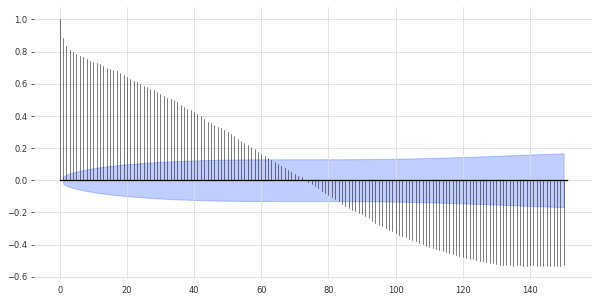

In [13]:
# plot its autocorrelation function
plot_acf(ts, max_lag=150)

In [14]:
# split training vs test dataset
train, val = ts.split_after(0.8)

In [15]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [74]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

ValueError: Timestamp must be between 1970-01-01 00:00:00 and 1972-09-26 00:00:00

# Run the RNN Models

In [16]:
# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             # future_covariates=covariates,
             val_series=val,
             # val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [17]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [18]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

In [19]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=288,
        training_length=70,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    # pred = model_RNN.predict(n=FC_N, future_covariates=covariates)
    pred = model_RNN.predict(n=50)

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]
    


beginning the training of the LSTM RNN:


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 10.66 sec


Predicting: 427it [00:00, ?it/s]

LSTM : 
MAPE : 14.9305
RMSPE : 0.1575
RMSE : 0.0733
-R squared : 52.9467
se : 0.2598

beginning the training of the GRU RNN:


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

training of the GRU RNN has completed: 10.20 sec


Predicting: 427it [00:00, ?it/s]

GRU : 
MAPE : 15.5402
RMSPE : 0.1589
RMSE : 0.0751
-R squared : 59.0819
se : 0.2591

beginning the training of the Vanilla RNN:


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

training of the Vanilla RNN has completed: 5.98 sec


Predicting: 427it [00:00, ?it/s]

Vanilla : 
MAPE : 27.0099
RMSPE : 0.2277
RMSE : 0.1111
-R squared : 49.8847
se : 0.2600


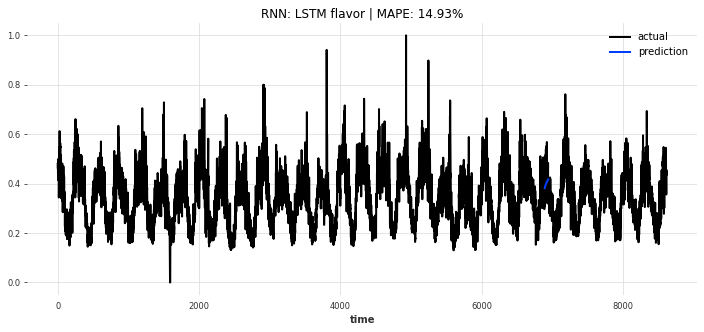

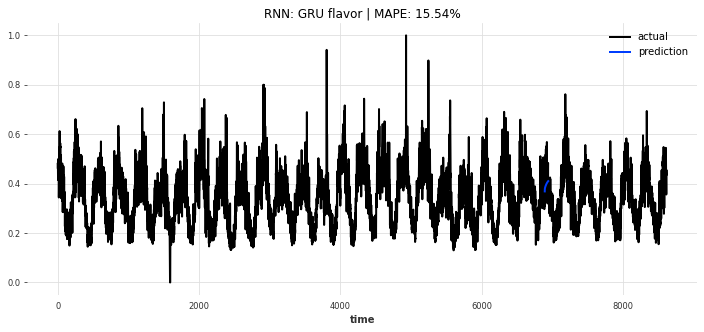

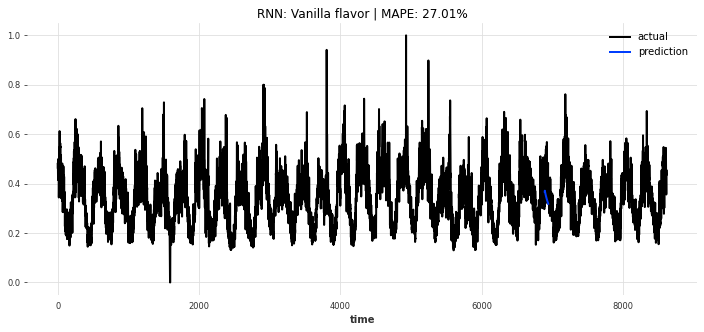

In [20]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]

# Compare with the Theta method

In [21]:
# Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
t_start =  time.perf_counter()
# search for best theta among 100 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)
    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta


# fit the model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred = best_theta_model.predict(len(val))

# review the Theta results
plt.figure(figsize=(12,5))
train.plot(label='actual: training set')
val.plot(label='actual: validation set')
pred.plot(label='Theta predictions')
plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
plt.legend();

res_time = time.perf_counter() - t_start
res_acc = accuracy_metrics(pred, val)
print("Theta forecast has completed: ", f'{res_time:.2f} sec')
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
results = [pred, res_acc]


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [103]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
    "Vanilla":res_flavors[2][1], "Theta":res_acc}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,LSTM,GRU,Vanilla,Theta
MAPE,4.113,5.007,3.929,3.112
RMSPE,0.045,0.053,0.044,0.045
RMSE,0.040,0.050,0.045,20.469
-R squared,-0.951,-0.912,-0.921,-0.899
se,0.165,0.180,0.186,6.218
